In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [102]:
runs = [304125,302263,304508]
cnorm = 2
with open("good_data_CNorm"+str(cnorm)+".pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1


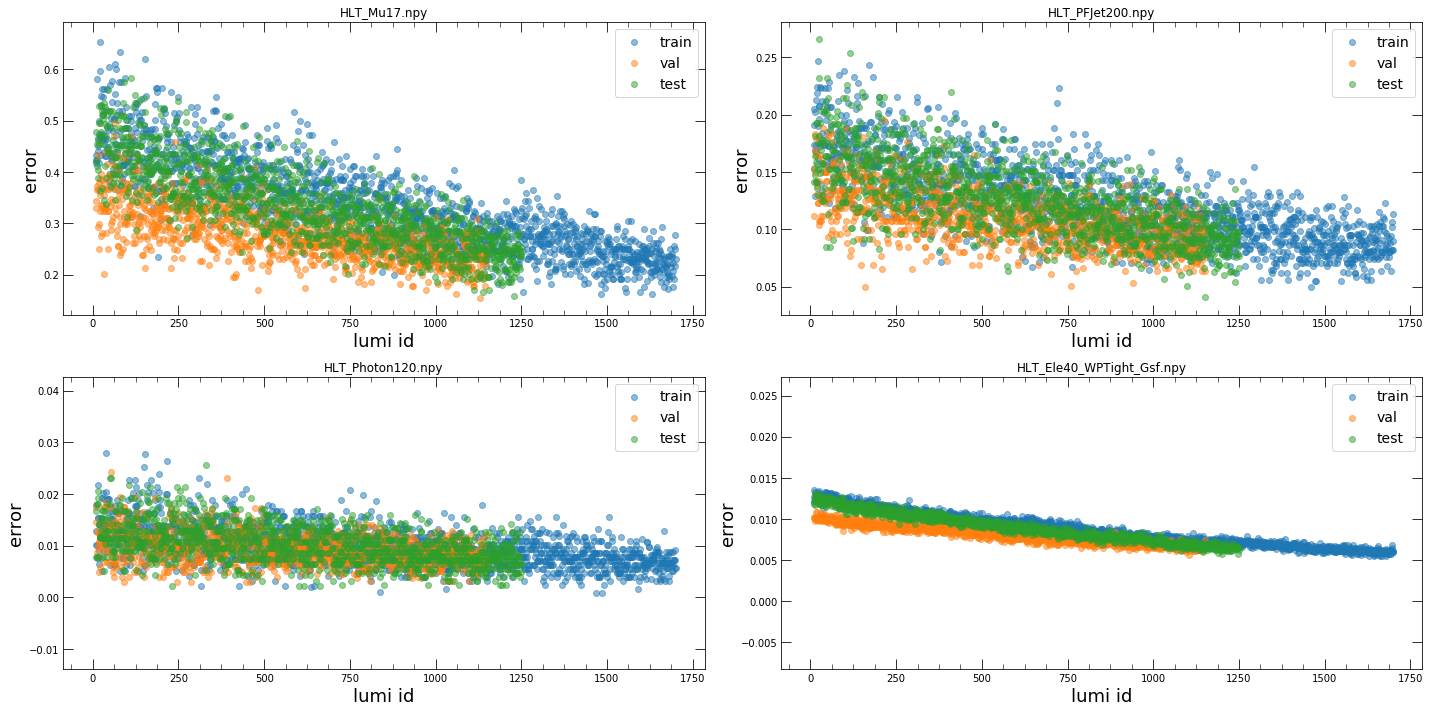

In [103]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [9]:
model_name = "simplest_" + str(cnorm)

In [10]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
reconstructed (Dense)        (None, 4)                 16        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1129 samples
Epoch 1/1000
 - 0s - loss: 1.8028 - val_loss: 1.2700
Epoch 2/1000
 - 0s - loss: 1.7563 - val_loss: 1.2372
Epoch 3/1000
 - 0s - loss: 1.7107 - val_loss: 1.2051
Epoch 4/1000
 - 0s - loss: 1.6664 - val_loss: 1.1736
Epoch 5/1000
 - 0s - loss: 1.6231 - val_loss: 1.1431
Epoch 6/1000
 - 0s - loss: 1.5808 - val_loss: 1.1131
Epoch 7/1000
 - 0s - loss: 1.5393 - val_loss: 1.0837
Epoch 8/1000
 - 0s - loss: 1.4986 - val_loss: 1.0550
Epoch 9/1000
 - 0s - loss: 1.4589 - val_loss: 1.0270
Epoch 10/1000
 - 0s - loss: 1.4204 - val_loss: 0.9998
Epoch 11/1000
 - 0s - loss: 1.3825 - val_loss: 0.9733
Epoch 12/1000
 - 0s - loss: 1.3460 - val_loss: 0.9476
Epoch 13/1000
 - 0s - loss: 1.3104 - val_loss: 0.9224
Epoch 14/1000
 - 0s - loss: 1.2757 - val_loss: 0.8980
Epoch 15/1000
 - 0s - loss: 1.2419 - val_loss: 0.8743
Epoch 16/1000
 - 0s - loss: 1.2090 - val_loss: 0.8512
Epoch 17/1000
 - 0s - loss: 1.1771 - val_loss: 0.8288
Epoch 18/1000
 - 0s - loss: 1.1464 - val_lo

Epoch 152/1000
 - 0s - loss: 0.0749 - val_loss: 0.0528
Epoch 153/1000
 - 0s - loss: 0.0738 - val_loss: 0.0520
Epoch 154/1000
 - 0s - loss: 0.0727 - val_loss: 0.0512
Epoch 155/1000
 - 0s - loss: 0.0716 - val_loss: 0.0505
Epoch 156/1000
 - 0s - loss: 0.0705 - val_loss: 0.0497
Epoch 157/1000
 - 0s - loss: 0.0695 - val_loss: 0.0490
Epoch 158/1000
 - 0s - loss: 0.0685 - val_loss: 0.0483
Epoch 159/1000
 - 0s - loss: 0.0675 - val_loss: 0.0476
Epoch 160/1000
 - 0s - loss: 0.0665 - val_loss: 0.0469
Epoch 161/1000
 - 0s - loss: 0.0656 - val_loss: 0.0462
Epoch 162/1000
 - 0s - loss: 0.0646 - val_loss: 0.0455
Epoch 163/1000
 - 0s - loss: 0.0637 - val_loss: 0.0449
Epoch 164/1000
 - 0s - loss: 0.0628 - val_loss: 0.0442
Epoch 165/1000
 - 0s - loss: 0.0619 - val_loss: 0.0436
Epoch 166/1000
 - 0s - loss: 0.0610 - val_loss: 0.0430
Epoch 167/1000
 - 0s - loss: 0.0602 - val_loss: 0.0424
Epoch 168/1000
 - 0s - loss: 0.0593 - val_loss: 0.0418
Epoch 169/1000
 - 0s - loss: 0.0585 - val_loss: 0.0412
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0134 - val_loss: 0.0093
Epoch 302/1000
 - 0s - loss: 0.0133 - val_loss: 0.0092
Epoch 303/1000
 - 0s - loss: 0.0131 - val_loss: 0.0091
Epoch 304/1000
 - 0s - loss: 0.0130 - val_loss: 0.0090
Epoch 305/1000
 - 0s - loss: 0.0129 - val_loss: 0.0089
Epoch 306/1000
 - 0s - loss: 0.0128 - val_loss: 0.0088
Epoch 307/1000
 - 0s - loss: 0.0127 - val_loss: 0.0088
Epoch 308/1000
 - 0s - loss: 0.0125 - val_loss: 0.0087
Epoch 309/1000
 - 0s - loss: 0.0124 - val_loss: 0.0086
Epoch 310/1000
 - 0s - loss: 0.0123 - val_loss: 0.0085
Epoch 311/1000
 - 0s - loss: 0.0122 - val_loss: 0.0084
Epoch 312/1000
 - 0s - loss: 0.0121 - val_loss: 0.0084
Epoch 313/1000
 - 0s - loss: 0.0120 - val_loss: 0.0083
Epoch 314/1000
 - 0s - loss: 0.0119 - val_loss: 0.0082
Epoch 315/1000
 - 0s - loss: 0.0118 - val_loss: 0.0081
Epoch 316/1000
 - 0s - loss: 0.0117 - val_loss: 0.0081
Epoch 317/1000
 - 0s - loss: 0.0116 - val_loss: 0.0080
Epoch 318/1000
 - 0s - loss: 0.0114 - val_loss: 0.0079
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0039 - val_loss: 0.0027
Epoch 451/1000
 - 0s - loss: 0.0039 - val_loss: 0.0026
Epoch 452/1000
 - 0s - loss: 0.0039 - val_loss: 0.0026
Epoch 453/1000
 - 0s - loss: 0.0038 - val_loss: 0.0026
Epoch 454/1000
 - 0s - loss: 0.0038 - val_loss: 0.0026
Epoch 455/1000
 - 0s - loss: 0.0038 - val_loss: 0.0026
Epoch 456/1000
 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 457/1000
 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 458/1000
 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 459/1000
 - 0s - loss: 0.0037 - val_loss: 0.0025
Epoch 460/1000
 - 0s - loss: 0.0036 - val_loss: 0.0025
Epoch 461/1000
 - 0s - loss: 0.0036 - val_loss: 0.0025
Epoch 462/1000
 - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 463/1000
 - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 464/1000
 - 0s - loss: 0.0035 - val_loss: 0.0024
Epoch 465/1000
 - 0s - loss: 0.0035 - val_loss: 0.0024
Epoch 466/1000
 - 0s - loss: 0.0035 - val_loss: 0.0024
Epoch 467/1000
 - 0s - loss: 0.0035 - val_loss: 0.0024
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0015 - val_loss: 9.8925e-04
Epoch 600/1000
 - 0s - loss: 0.0014 - val_loss: 9.8347e-04
Epoch 601/1000
 - 0s - loss: 0.0014 - val_loss: 9.7774e-04
Epoch 602/1000
 - 0s - loss: 0.0014 - val_loss: 9.7206e-04
Epoch 603/1000
 - 0s - loss: 0.0014 - val_loss: 9.6643e-04
Epoch 604/1000
 - 0s - loss: 0.0014 - val_loss: 9.6081e-04
Epoch 605/1000
 - 0s - loss: 0.0014 - val_loss: 9.5523e-04
Epoch 606/1000
 - 0s - loss: 0.0014 - val_loss: 9.4970e-04
Epoch 607/1000
 - 0s - loss: 0.0014 - val_loss: 9.4422e-04
Epoch 608/1000
 - 0s - loss: 0.0014 - val_loss: 9.3879e-04
Epoch 609/1000
 - 0s - loss: 0.0014 - val_loss: 9.3339e-04
Epoch 610/1000
 - 0s - loss: 0.0014 - val_loss: 9.2804e-04
Epoch 611/1000
 - 0s - loss: 0.0014 - val_loss: 9.2273e-04
Epoch 612/1000
 - 0s - loss: 0.0013 - val_loss: 9.1746e-04
Epoch 613/1000
 - 0s - loss: 0.0013 - val_loss: 9.1224e-04
Epoch 614/1000
 - 0s - loss: 0.0013 - val_loss: 9.0705e-04
Epoch 615/1000
 - 0s - loss: 0.0013 - val_loss: 9.0188e-

 - 0s - loss: 7.1619e-04 - val_loss: 4.9858e-04
Epoch 734/1000
 - 0s - loss: 7.1301e-04 - val_loss: 4.9648e-04
Epoch 735/1000
 - 0s - loss: 7.0981e-04 - val_loss: 4.9439e-04
Epoch 736/1000
 - 0s - loss: 7.0666e-04 - val_loss: 4.9231e-04
Epoch 737/1000
 - 0s - loss: 7.0352e-04 - val_loss: 4.9023e-04
Epoch 738/1000
 - 0s - loss: 7.0041e-04 - val_loss: 4.8816e-04
Epoch 739/1000
 - 0s - loss: 6.9730e-04 - val_loss: 4.8609e-04
Epoch 740/1000
 - 0s - loss: 6.9425e-04 - val_loss: 4.8404e-04
Epoch 741/1000
 - 0s - loss: 6.9119e-04 - val_loss: 4.8202e-04
Epoch 742/1000
 - 0s - loss: 6.8819e-04 - val_loss: 4.8002e-04
Epoch 743/1000
 - 0s - loss: 6.8518e-04 - val_loss: 4.7803e-04
Epoch 744/1000
 - 0s - loss: 6.8219e-04 - val_loss: 4.7605e-04
Epoch 745/1000
 - 0s - loss: 6.7922e-04 - val_loss: 4.7407e-04
Epoch 746/1000
 - 0s - loss: 6.7631e-04 - val_loss: 4.7211e-04
Epoch 747/1000
 - 0s - loss: 6.7340e-04 - val_loss: 4.7018e-04
Epoch 748/1000
 - 0s - loss: 6.7050e-04 - val_loss: 4.6825e-04
Epoch 7

Epoch 864/1000
 - 0s - loss: 4.4572e-04 - val_loss: 3.2005e-04
Epoch 865/1000
 - 0s - loss: 4.4451e-04 - val_loss: 3.1928e-04
Epoch 866/1000
 - 0s - loss: 4.4331e-04 - val_loss: 3.1850e-04
Epoch 867/1000
 - 0s - loss: 4.4211e-04 - val_loss: 3.1770e-04
Epoch 868/1000
 - 0s - loss: 4.4093e-04 - val_loss: 3.1692e-04
Epoch 869/1000
 - 0s - loss: 4.3975e-04 - val_loss: 3.1613e-04
Epoch 870/1000
 - 0s - loss: 4.3858e-04 - val_loss: 3.1533e-04
Epoch 871/1000
 - 0s - loss: 4.3742e-04 - val_loss: 3.1453e-04
Epoch 872/1000
 - 0s - loss: 4.3627e-04 - val_loss: 3.1376e-04
Epoch 873/1000
 - 0s - loss: 4.3513e-04 - val_loss: 3.1301e-04
Epoch 874/1000
 - 0s - loss: 4.3399e-04 - val_loss: 3.1227e-04
Epoch 875/1000
 - 0s - loss: 4.3287e-04 - val_loss: 3.1153e-04
Epoch 876/1000
 - 0s - loss: 4.3176e-04 - val_loss: 3.1081e-04
Epoch 877/1000
 - 0s - loss: 4.3065e-04 - val_loss: 3.1007e-04
Epoch 878/1000
 - 0s - loss: 4.2955e-04 - val_loss: 3.0934e-04
Epoch 879/1000
 - 0s - loss: 4.2845e-04 - val_loss: 3.0

 - 0s - loss: 3.4492e-04 - val_loss: 2.5363e-04
Epoch 995/1000
 - 0s - loss: 3.4446e-04 - val_loss: 2.5330e-04
Epoch 996/1000
 - 0s - loss: 3.4400e-04 - val_loss: 2.5300e-04
Epoch 997/1000
 - 0s - loss: 3.4355e-04 - val_loss: 2.5268e-04
Epoch 998/1000
 - 0s - loss: 3.4310e-04 - val_loss: 2.5236e-04
Epoch 999/1000
 - 0s - loss: 3.4266e-04 - val_loss: 2.5207e-04
Epoch 1000/1000
 - 0s - loss: 3.4222e-04 - val_loss: 2.5178e-04


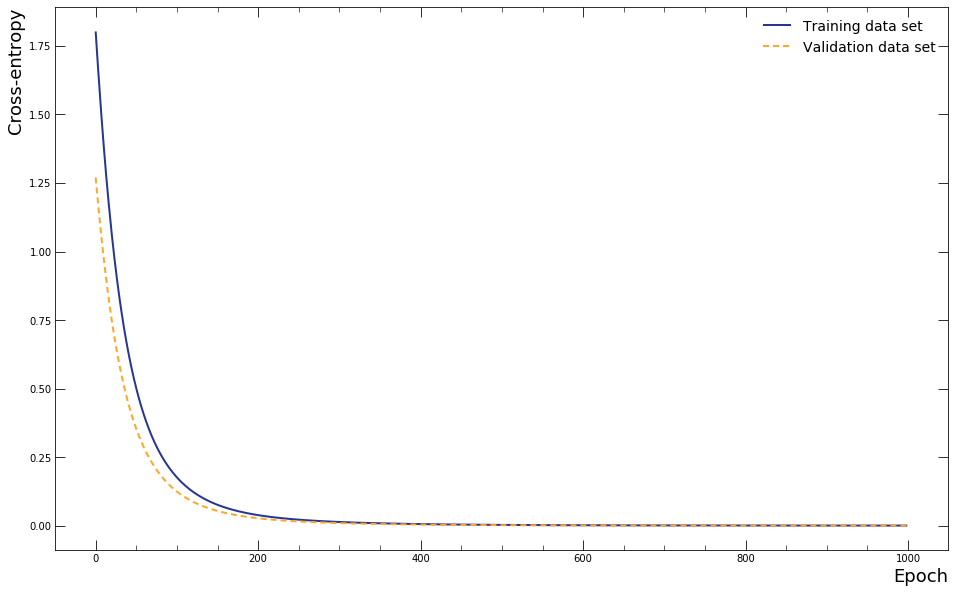

In [11]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

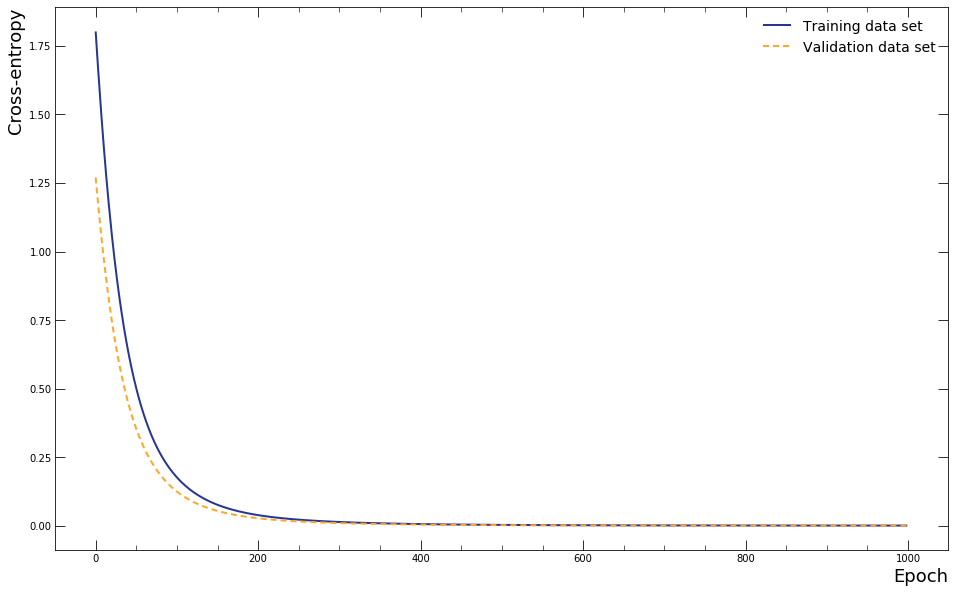

In [12]:
plot_loss(history)

## Training Set

In [104]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = abs(x_train_new-reconstructed)/x_train_new

In [105]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

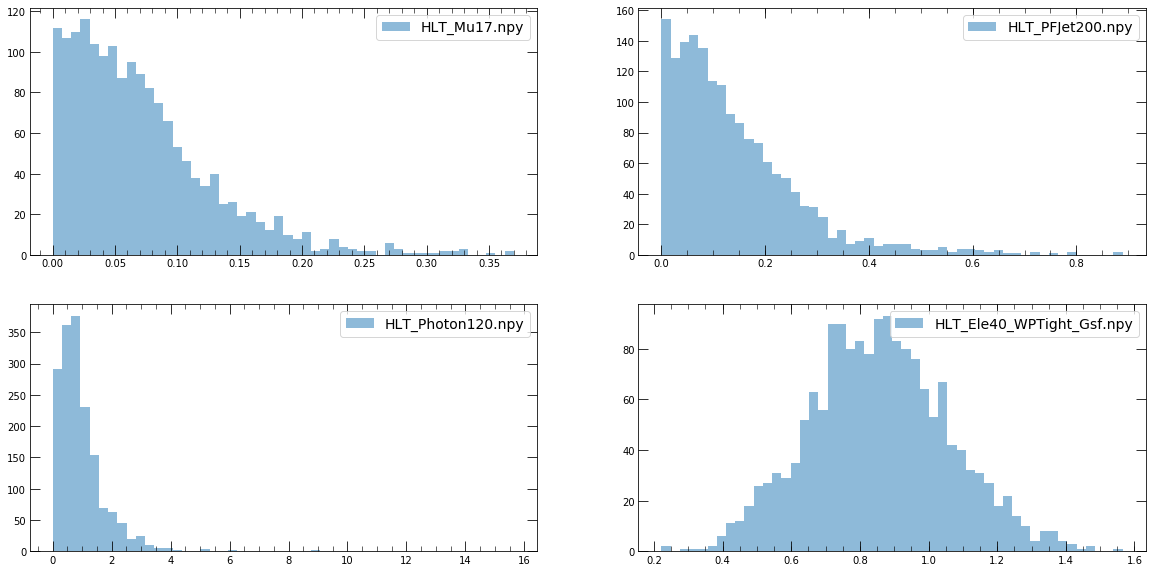

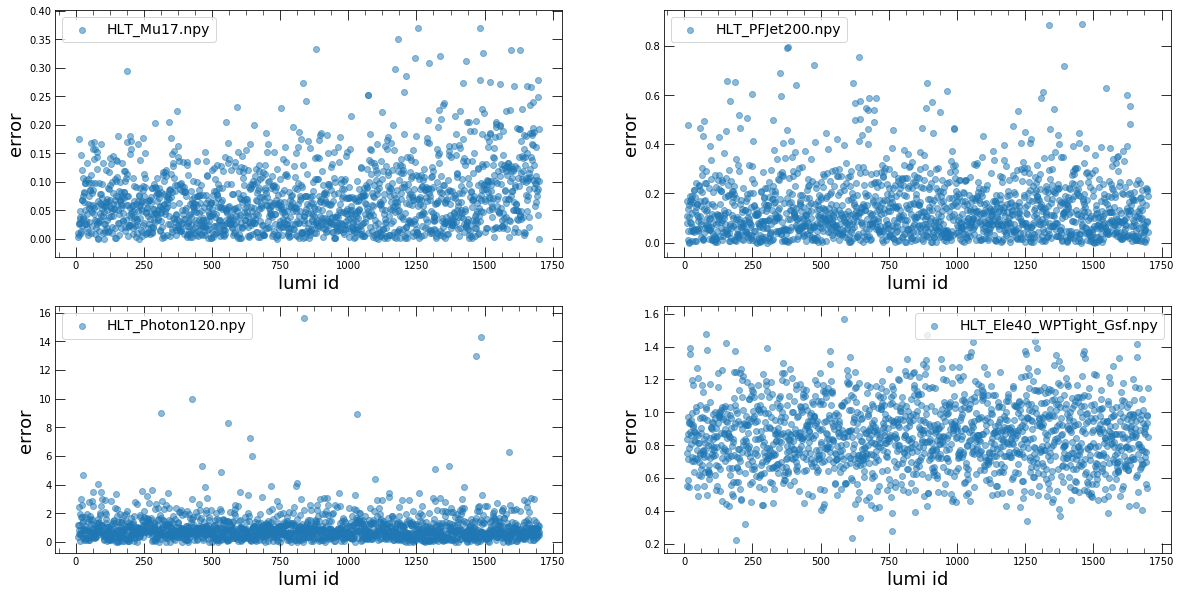

In [106]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

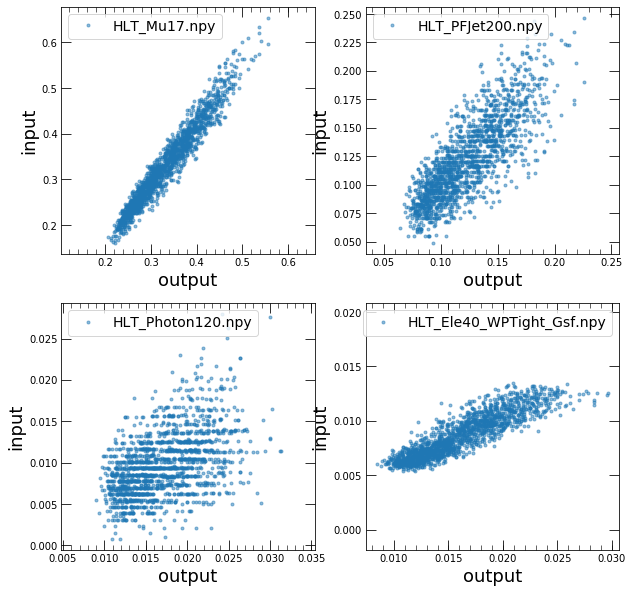

In [108]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [109]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [110]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

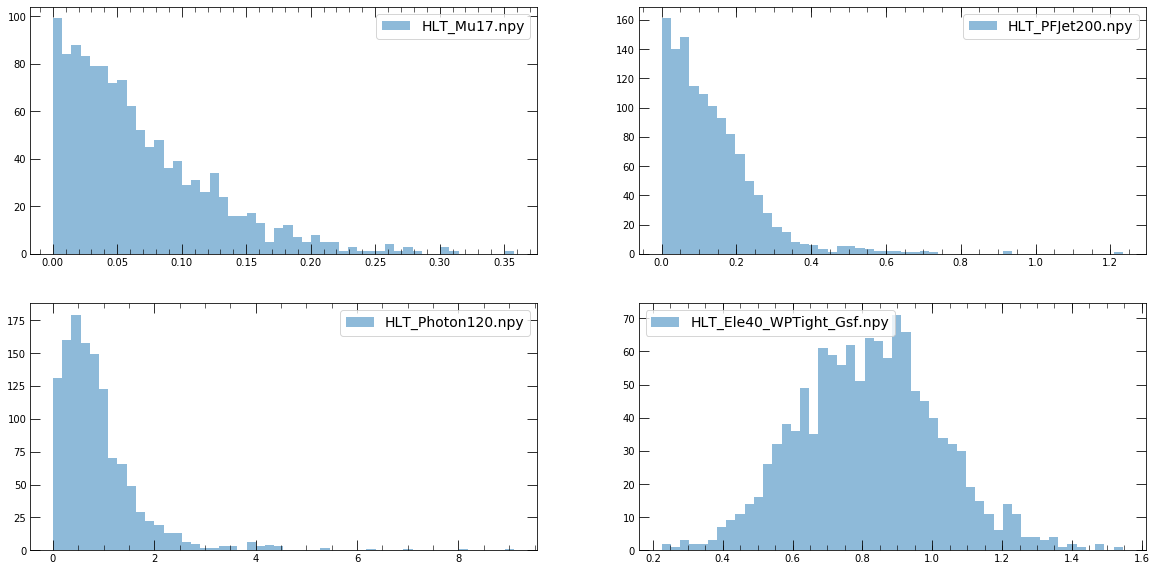

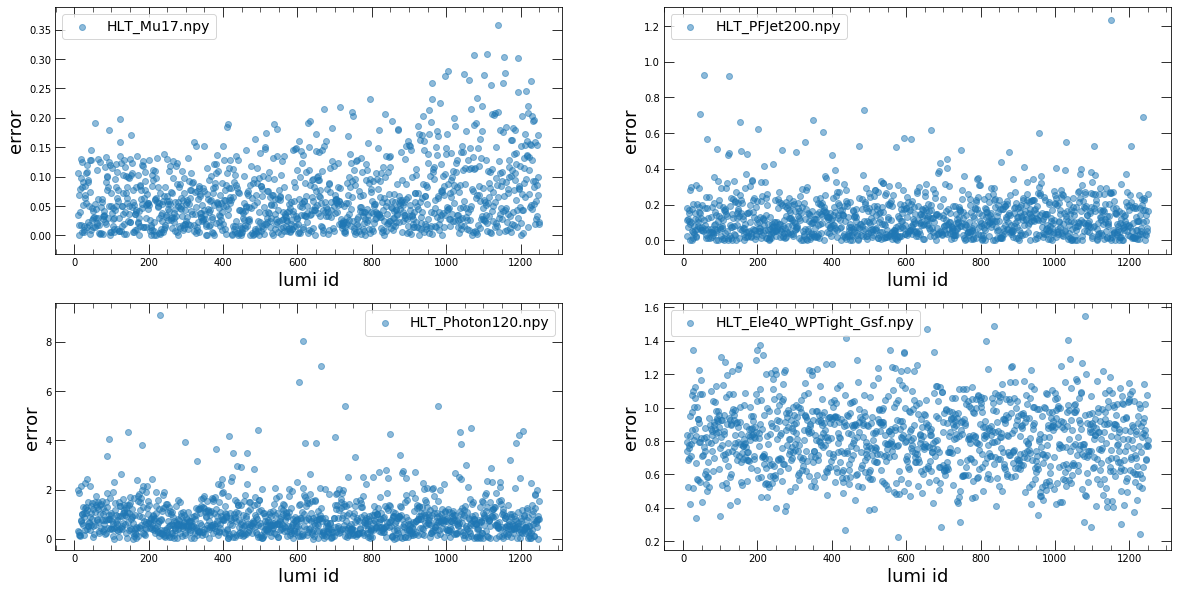

In [111]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

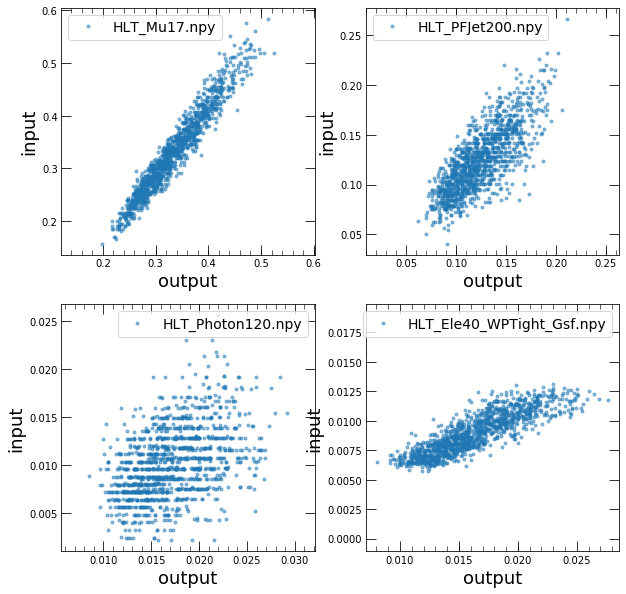

In [112]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [70]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [71]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [72]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [73]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [74]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


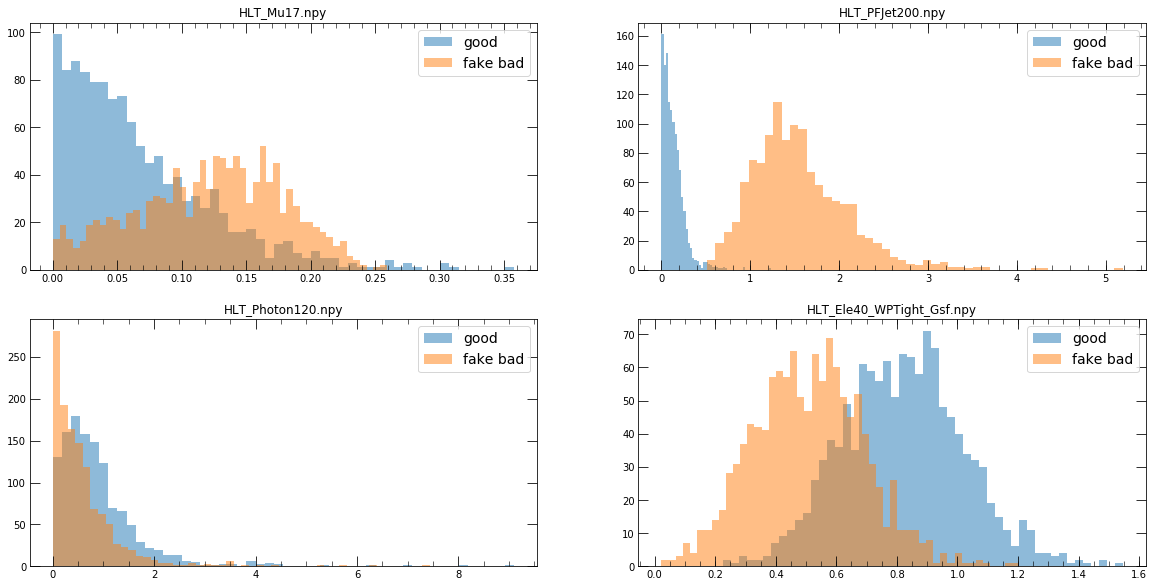

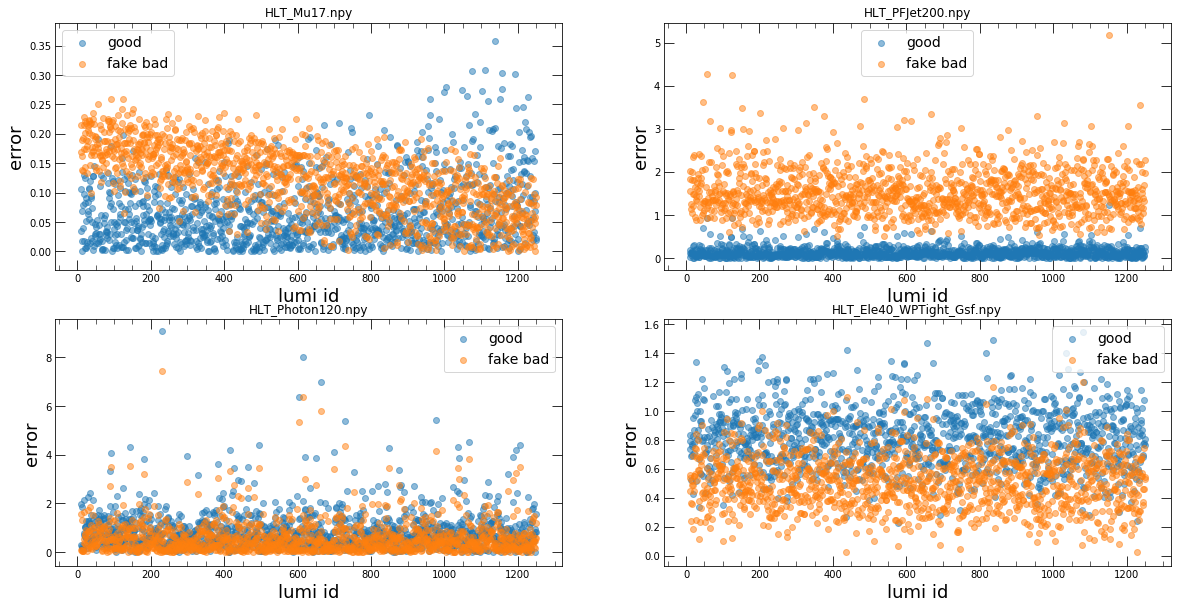

In [75]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

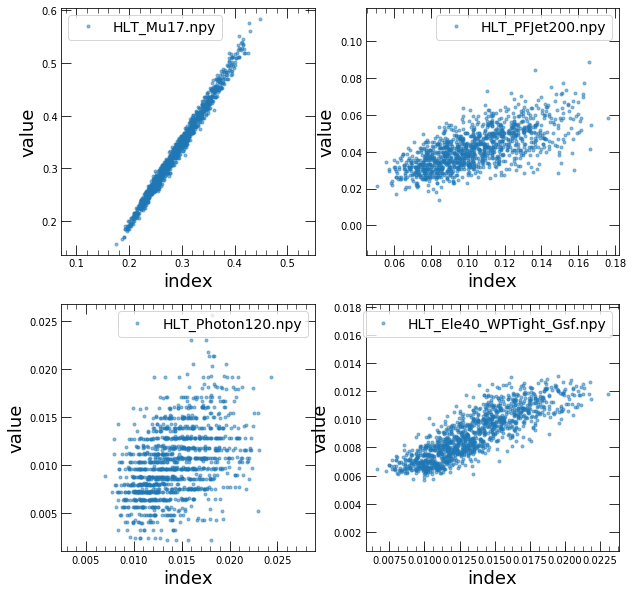

In [76]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [77]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [78]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [79]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [80]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [81]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


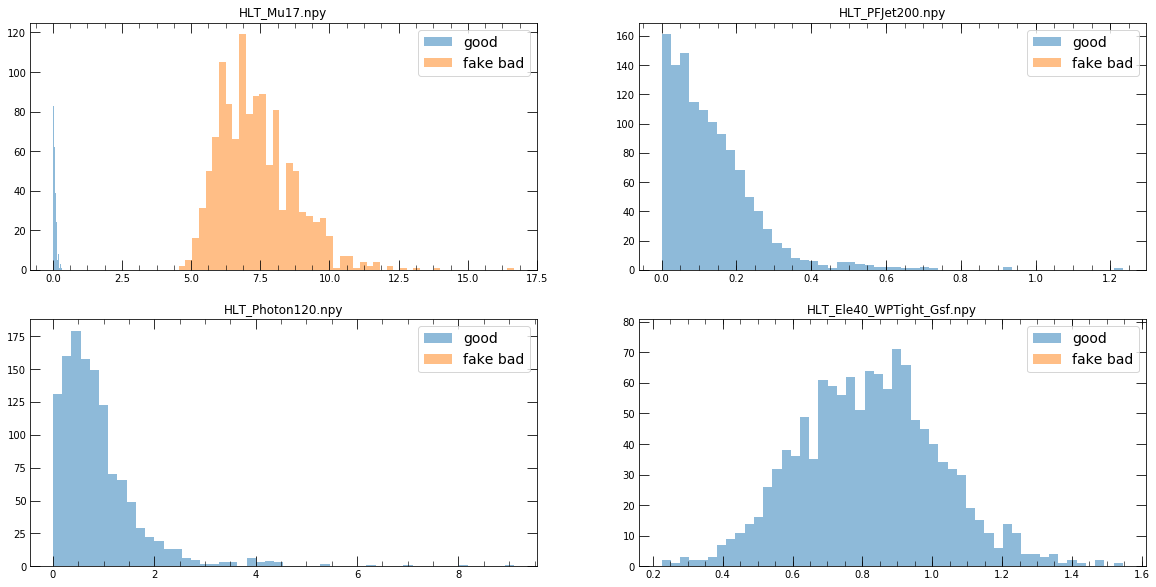

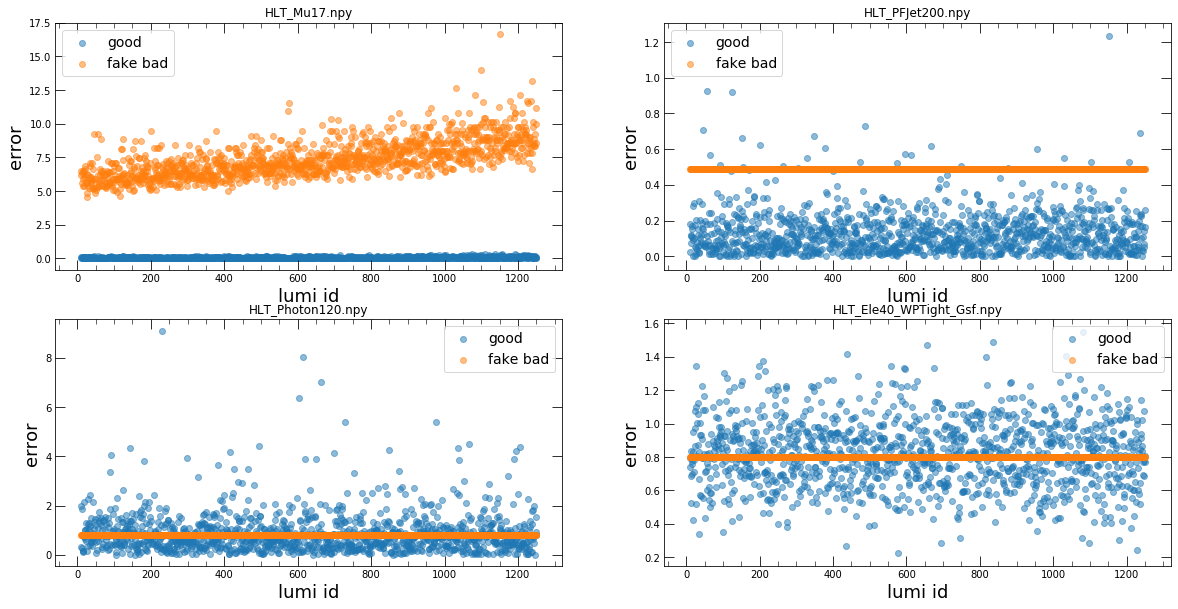

In [82]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

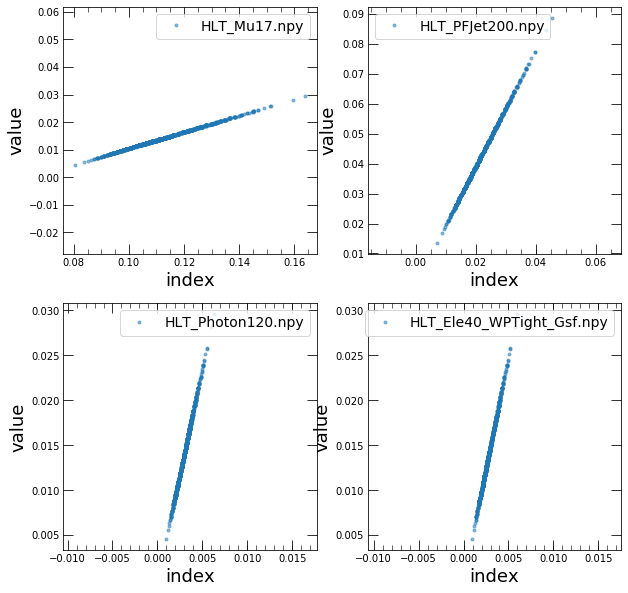

In [83]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [84]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [85]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [86]:
bad_runs = [301480]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [87]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [88]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


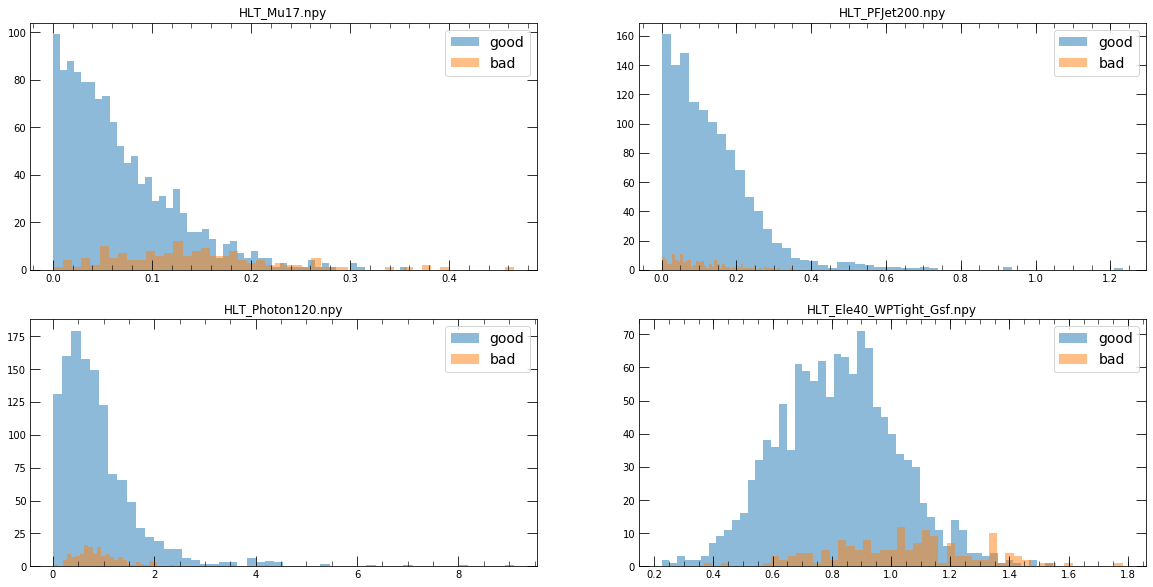

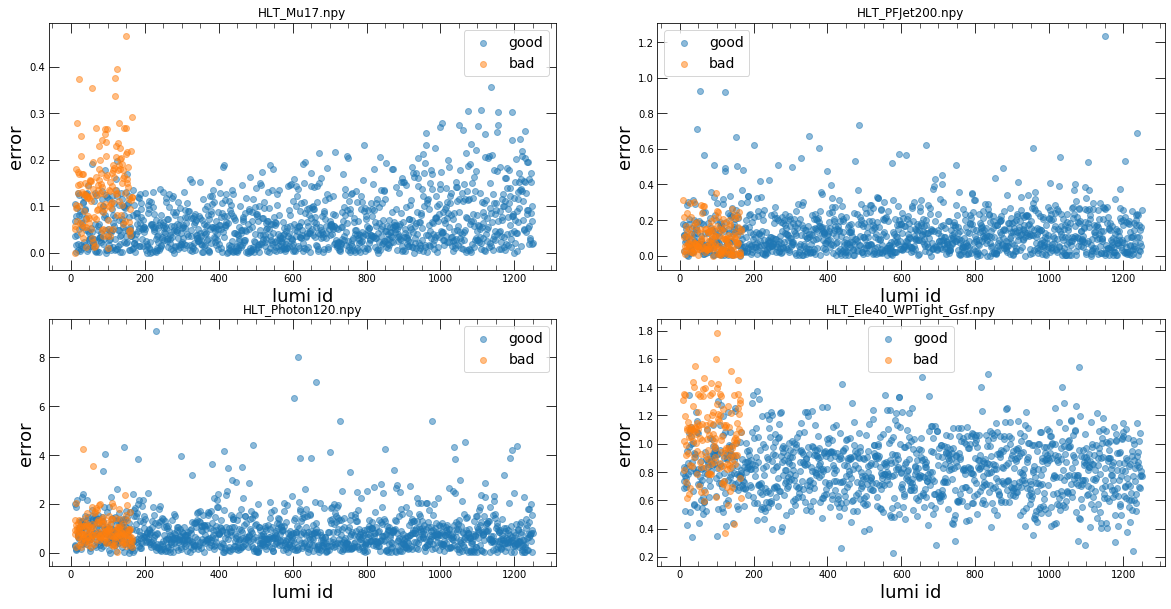

In [89]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

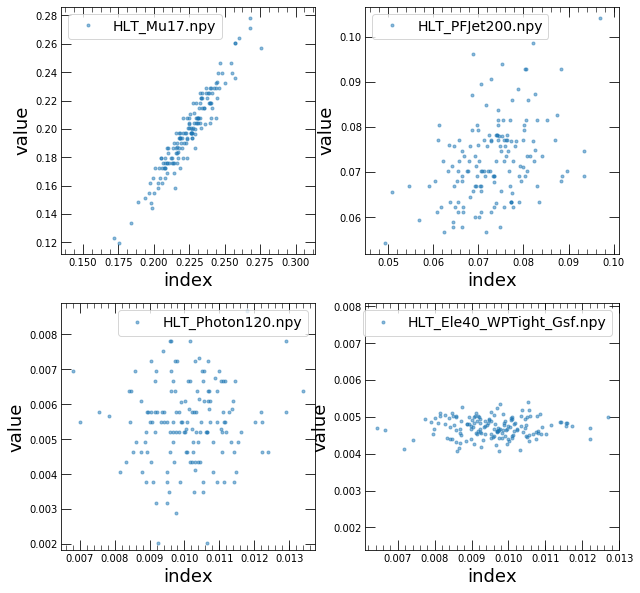

In [90]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [91]:
bad_runs = [305588]

with open("bad_data_CNorm" + str(cnorm) + ".pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [92]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [93]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


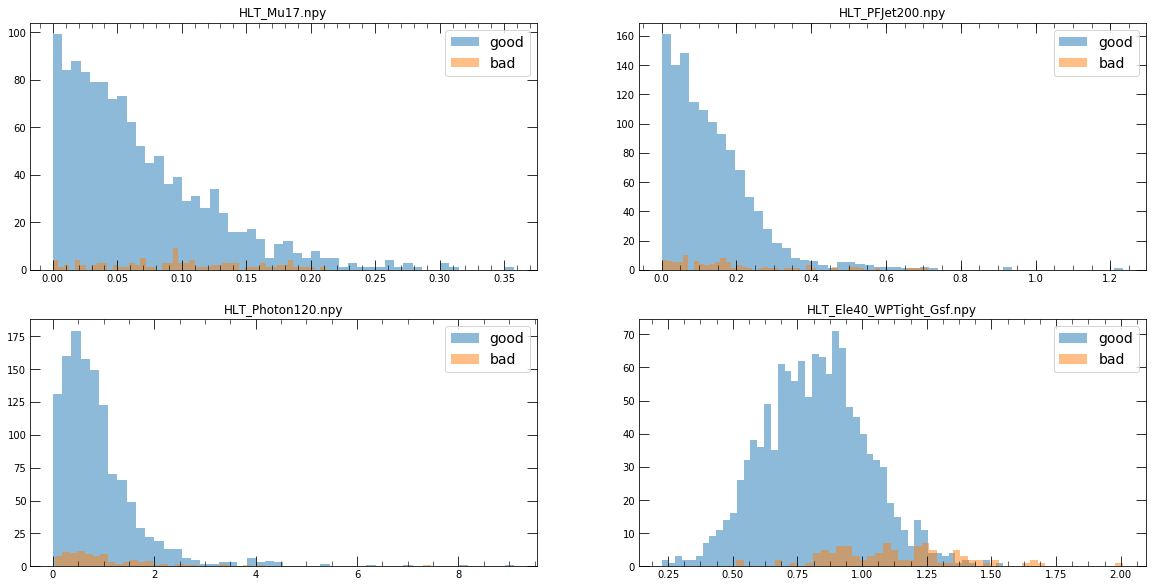

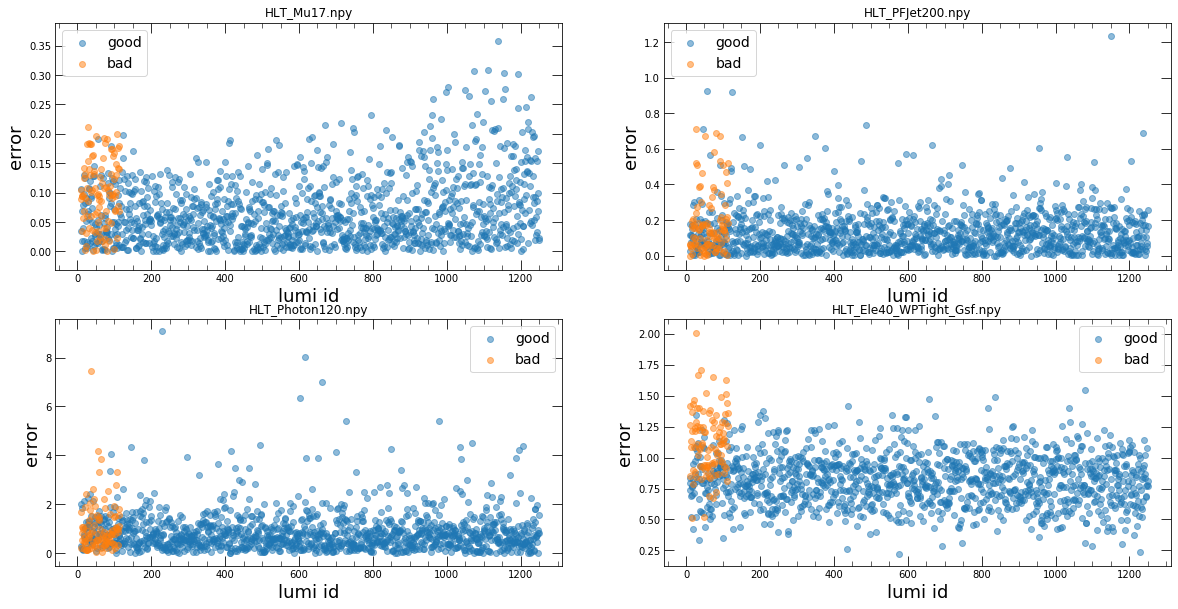

In [94]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

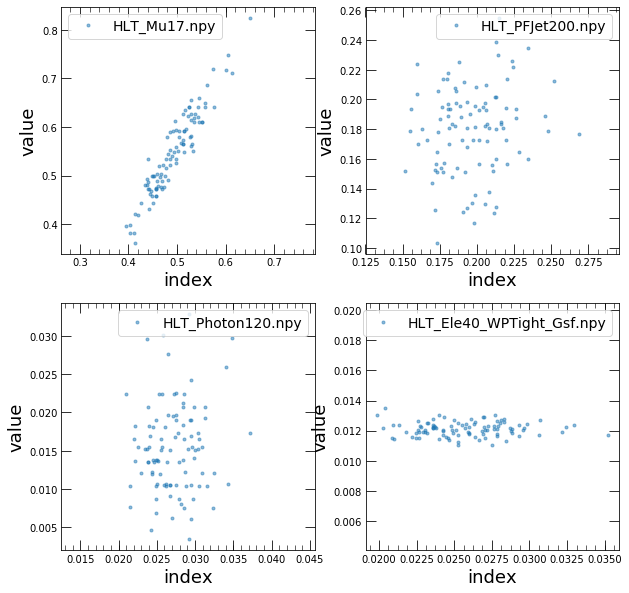

In [95]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()